In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import resource
import time
from datetime import datetime
import math
import os
from sklearn import preprocessing
import sys
#import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool

In [2]:
## Preprocessing of data
# Load data here:

#Split dataset to 10 partitions
a_k = .003
a_k2 = .005
lambda_ = 1
delta = 1

sample_num = 6000
max_iter = 100

curves = {}

#read the dataset
mnist_dataset = np.load("./mnist.npz")

#reshape x_train and x_test into matrices [x1|x2|....|xM]
M, D1, D2 = mnist_dataset['x_train'].shape
x_train = mnist_dataset['x_train'].reshape(M, D1 * D2).T
#add the bias dimension
x_train = np.vstack([x_train, np.ones((1, M))])
x_train = (x_train / np.linalg.norm(x_train, axis = 0))[:,:sample_num]
y_train = mnist_dataset['y_train'].reshape(M, 1).astype(int)[:sample_num]

M_test, D1, D2 = mnist_dataset['x_test'].shape
x_test = mnist_dataset['x_test'].reshape(M_test, D1 * D2).T
#add the bias dimension
x_test = np.vstack([x_test, np.ones((1, M_test))])
x_test = (x_test / np.linalg.norm(x_test, axis = 0))[:,:sample_num]
y_test = mnist_dataset['y_test'].reshape(M_test, 1).astype(int)[:sample_num]

#Split dataset to 10 partitions
workers_x = np.split(x_train, (np.arange(1, 10) * .1 * x_train.shape[1]).astype(int), axis = 1)
workers_y = np.split(np.array(y_train), (np.arange(1, 10) * .1 * x_train.shape[1]).astype(int), axis = 0)

In [3]:
#wrong classification percentage
def nmae(y,yhat):
    y = np.array(y).reshape(y.shape[0],1)
    yhat = np.array(yhat).reshape(yhat.shape[0],1)
    result = np.sum(y != yhat).astype(float)/(y.shape[0])
    return result

In [4]:
# ------------------------- SVM Classificaton ----------------------------------

#multiclass SVM classification loss and its gradient
def SVM_classify(x, w):
    return np.argmax(np.matmul(x.T, w), axis = 1).reshape(x.shape[1], 1)
def SVM_cost(x, y, w):
    svm_cost = (np.matmul(x.T, w) - np.repeat(np.multiply(x.T, w[:,y.reshape(y.shape[0])].T).sum(axis = 1).reshape(y.shape[0], 1), 10, axis = 1) + delta).clip(min = 0)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] = 0
    return svm_cost

def regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum() + lambda_/2 * np.linalg.norm(w)**2

def SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad_coef = svm_cost
    svm_cost_grad_coef[(range(y.shape[0]), y.reshape(y.shape[0]))] -= svm_cost.sum(axis=1)
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_grad[:, i] = np.multiply(svm_cost_grad_coef[:, i].reshape(svm_cost_grad_coef.shape[0], 1), x.T).sum(axis = 0)
    return svm_cost_grad

In [5]:
#binary SVM classification one-vs-rest loss and its gradient
def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    class_votes = np.zeros(scores.shape())
    class_votes[scores > 0] += 1
    for i in range(10):
        class_votes[scores[:,i] <= 0,:] += 1
    class_votes[scores <= 0] -= 1
    return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)
            
def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)

def bin_regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum(axis = 1) + lambda_/2 * np.linalg.norm(w, axis = 1)**2

def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi.T).sum(axis = 0) + lambda_ * w[:, i]
    return svm_cost_grad

In [6]:
#plot loss vs signaling at master node
def plot_master_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k]))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        T, loss = zip(*errs)
        plt.plot(T, loss, color = next(colors))
        legends.append(legend)
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    plt.title('Convergence vs signaling (%s)' % k)
    if len(legends) > 1:
        plt.legend(legends)
    plt.show()

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot greyscale plots of computed models of each digit
def plot_w_ks(w_k):
    fig, axarr = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        axarr[i // 5, i % 5].imshow(w_k[:28*28,i].reshape(28, 28), cmap='gray', interpolation='none')
        axarr[i // 5, i % 5].set_title("Digit: {}".format(i))
        axarr[i // 5, i % 5].set_xticks([])
        axarr[i // 5, i % 5].set_yticks([])

    plt.show()

In [8]:
#plot average agent loss vs signaling and the region between min and max loss
def plot_agents_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k].keys()))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        color = next(colors)
        T, losses = zip(*errs)
        legends.append(legend)
        losses = zip(*losses)
        losses = list(losses)
        mean = np.array(losses).mean(axis = 0)
        lmin = np.array(losses).min(axis = 0)
        lmax = np.array(losses).max(axis = 0)
        var = np.array(losses).var(axis = 0)
        plt.plot(T, mean, color = color)
        plt.fill_between(T, lmin, lmax,facecolor = color, alpha=0.2, edgecolor='none')
        #plt.fill_between(T, mean - var, mean + var,facecolor = color, alpha=0.2, edgecolor='none')
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    if len(legends) > 1:
        plt.legend(legends)
    plt.title('Convergence vs signaling (%s)' % k)
    plt.show()

In [9]:
#single agent GD SVM
def gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 

In [10]:
#single agent binary GD SVM
def bin_gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = np.linalg.norm(bin_regulated_total_cost(x, y, w_k, lambda_))
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = bin_SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = np.linalg.norm(regulated_total_cost(x, y, w_k, lambda_))
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs

In [11]:
#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with probability p
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    grad_w = SVM_cost_grad(x, y, w_k, lambda_)
    return 1, np.array(grad_w)


def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)


In [12]:
#Master updates the gradient w.r.t w_k for each class
def decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_):
    w_k = w_k - a_k * grad_w.mean(axis = 0).reshape(w_k.shape)
    return 10, w_k


#DGD
def decentralized_gradient_descent(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    T = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_])
        #results = []
        #for i in range(10):
        #    results.append(decentralized_gradient_descent_worker(*zipped[i]))
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        signals, grad_w = zip(*results)
        grad_w = np.array(grad_w)
        T += np.array(signals).sum()
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
        #master updates w_ks
        signals, w_k = master(w_k, a_k, grad_w, x, y, lambda_)
        T += signals
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append((T, L1))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs


In [13]:
#run DGD
print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized gradient descent'] = {'no compression':(w_k, errs)}

2020-05-20 14:26:32.382608
Final loss = 5320.375 and gradient norm = 203.099
2020-05-20 14:26:48.560054
Training classification error: 0.101
Test classification error: 0.141


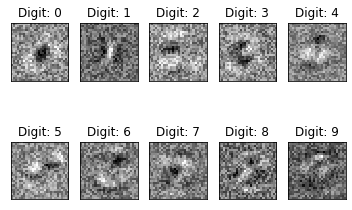

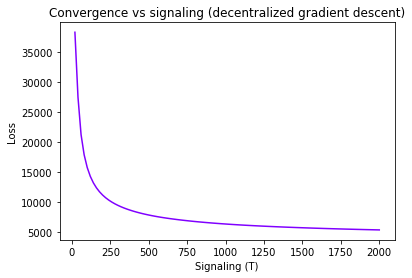

In [14]:
#plot greyscale models and master loss for DGD
plot_w_ks(curves['decentralized gradient descent']['no compression'][0])

plot_master_loss('decentralized gradient descent')

In [15]:
#communication graph
A = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]])

In [16]:
#agent process for decentralized subgradient method (DSM)

def decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = w_k[Ai == 1].mean(axis = 0)
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_)
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() - 1, bar_w_k, grad_w

def decentralized_subgradient_method_agent_(args):
    return decentralized_subgradient_method_agent(*args)


In [17]:
A_ADMM = A - np.eye(10) + np.diag((A - np.eye(10)).sum(axis = 0))

#agent process for ADMM
def admm_over_network_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = np.multiply(w_k, np.repeat(np.repeat(Ai.reshape(10, 1, 1), x.shape[0], axis = 1), 10, axis=2)).sum(axis = 0) / Ai.sum()
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_)
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() / 2, bar_w_k, grad_w

def admm_over_network_agent_(args):
    return admm_over_network_agent(*args)

In [18]:
#decentralized optimization over network
def decentralized_method(x, y, workers_x, workers_y, lambda_, a_k, max_iter, A, agent_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(10, x.shape[0], 10)
    T = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_)
    for k in range(max_iter):
        L = L1
        #transmit w_ks and 
        workers_w_k = np.array(10 * [w_k]).reshape(10, 10, x.shape[0], 10)
        if compress is not None:
            compressed_w_k = np.zeros((10, x.shape[0], 10))
            for i in range(10):
                compressed_w_k[i] = compress(w_k[i])
            workers_w_k = np.array(10 * [compressed_w_k]).reshape(10, 10, x.shape[0], 10)
            for i in range(10):
                workers_w_k[i, i] = w_k[i]
        #each agent gets a copy of w_ks of neighbors, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(A, workers_x, workers_y, workers_w_k, 10 * [lambda_], 10 * [a_k])
        #results = []
        #for i in range(10):
        #    results.append(decentralized_method_agent(*zipped[i]))
        pool = ThreadPool(10)
        results = pool.map(agent_, zipped)
        pool.close()
        pool.join()
        signals, w_k, grad_w = zip(*results)
        grad_w = np.array(grad_w)
        w_k = np.array(w_k)
        T += np.array(signals).sum()
        L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_)
        L1s = []
        for i in range(10):
            L1s.append(regulated_total_cost(x, y, w_k[i], lambda_))
        errs.append((T, L1s))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w.mean(axis = 0))))
    return w_k.mean(axis = 0).reshape(x.shape[0],10), errs

In [19]:
from datetime import datetime
#run DSM
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method'] = {'no compression':(w_k, errs)}

#run ADMM
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training accuracy: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test accuracy: %.3f" % nmae(y_test, y_predict))


curves['ADMM over network'] = {'no compression':(w_k, errs)}

2020-05-20 14:31:32.654297
Final loss = 4564.598 and gradient norm = 18.821
2020-05-20 14:32:13.425073
Training classification error: 0.091
Test classification error: 0.126
2020-05-20 14:32:13.432760
Final loss = 4676.346 and gradient norm = 21.295
2020-05-20 14:32:53.705561
Training accuracy: 0.092
Test accuracy: 0.127


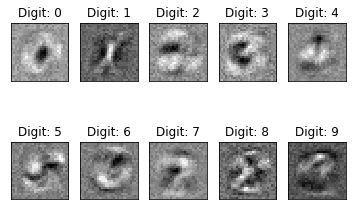

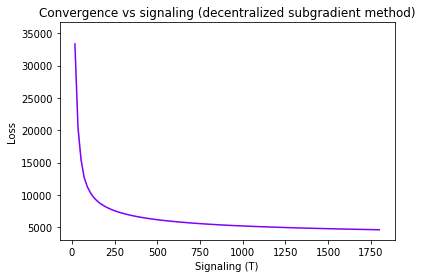

In [20]:
#plot greyscale models and average agent loss for DSM
plot_w_ks(curves['decentralized subgradient method']['no compression'][0])

plot_agents_loss('decentralized subgradient method')

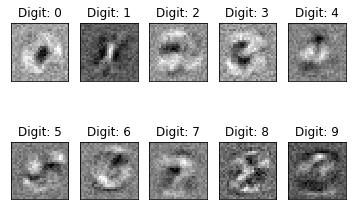

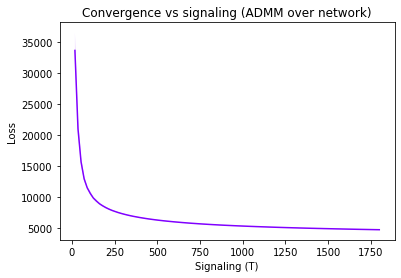

In [21]:
#plot greyscale models and average agent loss for ADMM
plot_w_ks(curves['ADMM over network']['no compression'][0])

plot_agents_loss('ADMM over network')

In [22]:
#To reduce T we propose to modify the algorithms in this way:
# we run single agent SVM optimization for a few iterations in each worker/agent and compute a few steps of GD individually at each agent
max_iter1 = 3
#In decentralized gradient descent workers share their overall direction.

def mod_decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    w_k1, errs = gradient_descent(x, y, w_k, lambda_, a_k, max_iter = max_iter1)
    return 1, np.array(w_k - w_k1)/a_k

def mod_decentralized_gradient_descent_worker_(args):
    return mod_decentralized_gradient_descent_worker(*args)

In [23]:
#run DGD with reduced communication
print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, mod_decentralized_gradient_descent_worker_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized gradient descent']['less communication'] = (w_k, errs)

2020-05-20 14:33:23.782008
Final loss = 4349.890 and gradient norm = 396.140
2020-05-20 14:34:00.558204
Training classification error: 0.085
Test classification error: 0.123


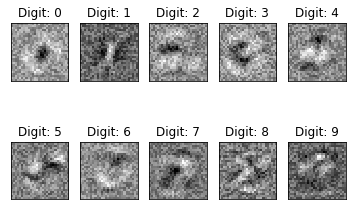

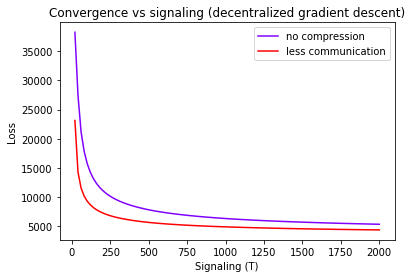

In [24]:
#plot greyscale models and master loss for DGD with less communication
plot_w_ks(curves['decentralized gradient descent']['less communication'][0])

plot_master_loss('decentralized gradient descent')

In [25]:
##In decentralized subgradient method agents share their final w_k model resulting from thier internal loop

def mod_decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = w_k[Ai == 1].mean(axis = 0)
    w_k1, errs = gradient_descent(x, y, bar_w_k, lambda_, a_k, max_iter = max_iter1)
    return Ai.sum() - 1, w_k1, np.array(w_k - w_k1) / a_k

def mod_decentralized_subgradient_method_agent_(args):
    return mod_decentralized_subgradient_method_agent(*args)

def mod_admm_over_network_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = np.multiply(w_k, np.repeat(np.repeat(Ai.reshape(10, 1, 1), x.shape[0], axis = 1), 10, axis=2)).sum(axis = 0) / Ai.sum()
    w_k1, errs = gradient_descent(x, y, bar_w_k, lambda_, a_k, max_iter = max_iter1)
    return Ai.sum() / 2,w_k1, np.array(w_k - w_k1) / a_k

def mod_admm_over_network_agent_(args):
    return mod_admm_over_network_agent(*args)

In [26]:
#run DSM with less communication
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, mod_decentralized_subgradient_method_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method']['less communication'] = (w_k, errs)

#run ADMM with less communication
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, mod_admm_over_network_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))


curves['ADMM over network']['less communication'] = (w_k, errs)

2020-05-20 14:34:36.819332
Final loss = 3903.573 and gradient norm = 852.161
2020-05-20 14:35:37.450085
Training classification error: 0.077
Test classification error: 0.116
2020-05-20 14:35:37.459459
Final loss = 4014.320 and gradient norm = 988.852
2020-05-20 14:36:41.385873
Training classification error: 0.080
Test classification error: 0.121


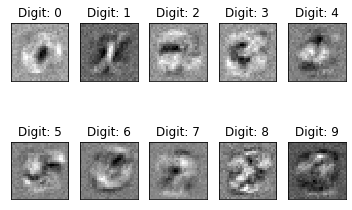

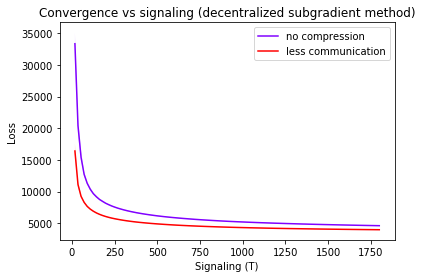

In [27]:
#plot greyscale models and average agent loss for DSM with less communication
plot_w_ks(curves['decentralized subgradient method']['less communication'][0])

plot_agents_loss('decentralized subgradient method')

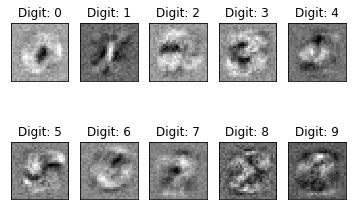

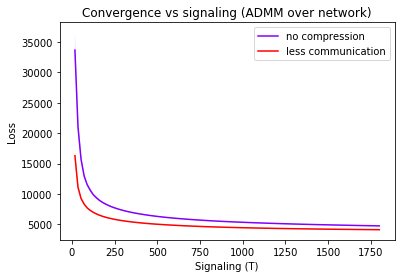

In [28]:
#plot greyscale models and average agent loss for ADMM with less communication
plot_w_ks(curves['ADMM over network']['less communication'][0])

plot_agents_loss('ADMM over network')

In [29]:
#Q1 and Q2 compression functions
imcenterinds = (np.arange(0, 14*14).reshape(14, 14) + 7 + 28 * 7 + np.repeat(np.arange(0, 14).reshape(14, 1) * 14, 14, axis = 1)).reshape(14*14)

def Q1_of_w(w):
    w1 = np.zeros(w.shape)
    for i in range(10):
        w1[(imcenterinds,len(imcenterinds) * [i])] = w[(imcenterinds,len(imcenterinds) * [i])]
        w1[784, i] = w[784, i]
    return w1

def Q2_of_w(w):
    return w.astype(np.float16).astype(np.float64)


In [30]:
#run DGD with Q1 and Q2 compression
print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_, compress = Q1_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized gradient descent']['Q1'] = (w_k, errs)

print(datetime.now())
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_, compress = Q2_of_w)
print(datetime.now())


y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized gradient descent']['Q2'] = (w_k, errs)

2020-05-20 14:41:32.118131
Final loss = 5787.117 and gradient norm = 203.590
2020-05-20 14:41:49.175483
Training classification error: 0.137
Test classification error: 0.179
2020-05-20 14:41:49.184024
Final loss = 5318.421 and gradient norm = 202.468
2020-05-20 14:42:06.105261
Training classification error: 0.104
Test classification error: 0.144


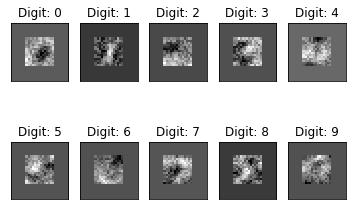

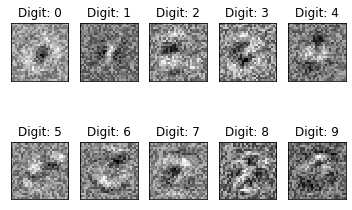

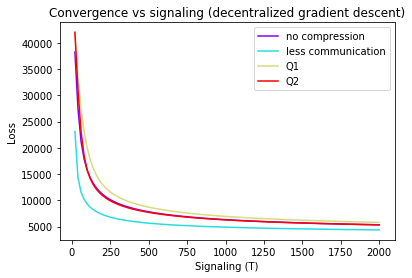

In [31]:
#plot greyscale models and master loss for compressed DGD
plot_w_ks(curves['decentralized gradient descent']['Q1'][0])

plot_w_ks(curves['decentralized gradient descent']['Q2'][0])

plot_master_loss('decentralized gradient descent')

In [32]:
#run DSM with Q1 and Q2 compression
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_, compress = Q1_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method']['Q1'] = (w_k, errs)

print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_, compress = Q2_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method']['Q2'] = (w_k, errs)

#run ADMM with Q1 and Q2 compression
print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_, compress = Q1_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['ADMM over network']['Q1'] = (w_k, errs)

print(datetime.now())
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_, compress = Q2_of_w)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['ADMM over network']['Q2'] = (w_k, errs)

2020-05-20 14:44:32.768567
Final loss = 5116.052 and gradient norm = 35.170
2020-05-20 14:45:14.004979
Training classification error: 0.122
Test classification error: 0.166
2020-05-20 14:45:14.016856
Final loss = 4564.544 and gradient norm = 18.276
2020-05-20 14:45:58.860419
Training classification error: 0.091
Test classification error: 0.126
2020-05-20 14:45:58.868468
Final loss = 5205.428 and gradient norm = 38.945
2020-05-20 14:46:40.027370
Training classification error: 0.123
Test classification error: 0.165
2020-05-20 14:46:40.035307
Final loss = 4678.187 and gradient norm = 21.628
2020-05-20 14:47:22.614585
Training classification error: 0.091
Test classification error: 0.127


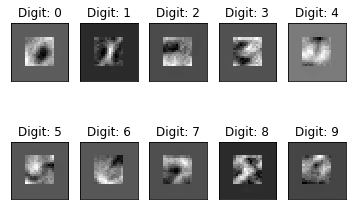

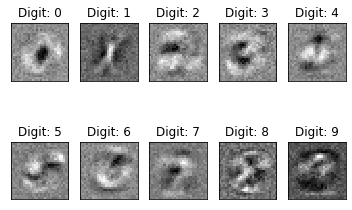

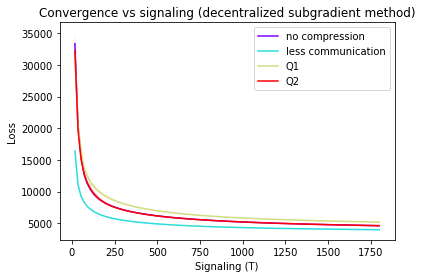

In [33]:
#plot greyscale models and average agent loss for compressed DSM
plot_w_ks(curves['decentralized subgradient method']['Q1'][0])

plot_w_ks(curves['decentralized subgradient method']['Q2'][0])

plot_agents_loss('decentralized subgradient method')

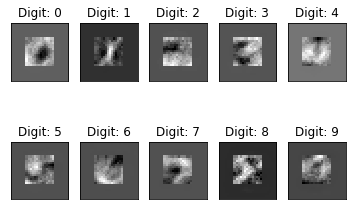

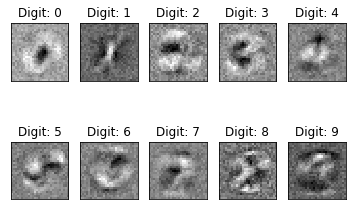

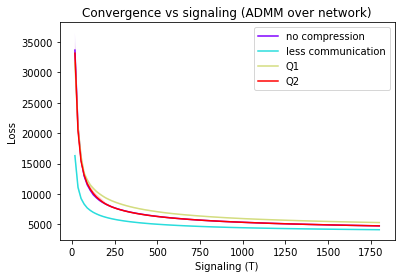

In [34]:
#plot greyscale models and average agent loss for compressed ADMM
plot_w_ks(curves['ADMM over network']['Q1'][0])

plot_w_ks(curves['ADMM over network']['Q2'][0])

plot_agents_loss('ADMM over network')

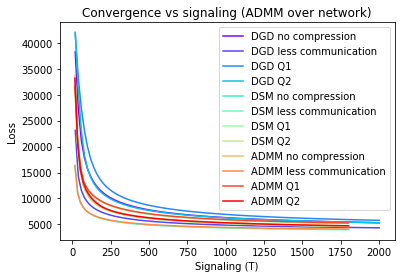

In [35]:
colors = iter(cm.rainbow(np.linspace(0, 1, 4 * 3)))
legends = []
k = 'decentralized gradient descent'
for legend in curves[k].keys():
    w_k, errs = curves[k][legend]
    T, loss = zip(*errs)
    plt.plot(T, loss, color = next(colors))
    legends.append('DGD %s' %(legend))

for k, l in [('decentralized subgradient method', 'DSM'), ('ADMM over network', 'ADMM')]:
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        color = next(colors)
        T, losses = zip(*errs)
        legends.append('%s %s' %(l,legend))
        losses = zip(*losses)
        losses = list(losses)
        mean = np.array(losses).mean(axis = 0)
        lmin = np.array(losses).min(axis = 0)
        lmax = np.array(losses).max(axis = 0)
        var = np.array(losses).var(axis = 0)
        plt.plot(T, mean, color = color)
        plt.fill_between(T, lmin, lmax,facecolor = color, alpha=0.2, edgecolor='none')
        #plt.fill_between(T, mean - var, mean + var,facecolor = color, alpha=0.2, edgecolor='none')

plt.xlabel("Signaling (T)")
plt.ylabel("Loss")
#plt.yscale("log")
plt.title('Convergence vs signaling (%s)' % k)
if len(legends) > 1:
    plt.legend(legends)
plt.show()